## 1. Install Dependencies

## 0. Configuration (Test Mode)

In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"
TEST_MODE = False  
TEST_SAMPLE_SIZE = 300      
TEST_MAX_EPOCHS = 5         
TEST_BATCH_SIZE = 8         
FULL_MAX_EPOCHS = 10
FULL_BATCH_SIZE = 16
TRAIN_DEBERTA_BASE = True
TRAIN_DEBERTA_LARGE = True  
TRAIN_LEGAL_BERT = True
TRAIN_BILSTM_CRF = True      
BILSTM_CONFIG = {
    'test': {
        'epochs': 5,
        'batch_size': 16,  
        'lr': 0.002,
        'hidden_dim': 256,
        'num_layers': 2,
        'dropout': 0.5,
        'grad_clip': 5.0
    },
    'full': {
        'epochs': 15,
        'batch_size': 64,
        'lr': 0.001,
        'hidden_dim': 256,
        'num_layers': 2,
        'dropout': 0.5,
        'grad_clip': 5.0,
        'lr_patience': 2,
        'lr_factor': 0.5
    }
}
if TEST_MODE:
    print(" TEST MODE ENABLED")
    print(f"   - Sample size: {TEST_SAMPLE_SIZE}")
    print(f"   - Max epochs: {TEST_MAX_EPOCHS}")
    print(f"   - Batch size: {TEST_BATCH_SIZE}")
    print(f"   - Models: DeBERTa-base={TRAIN_DEBERTA_BASE}, DeBERTa-large={TRAIN_DEBERTA_LARGE}, Legal-BERT={TRAIN_LEGAL_BERT}, BiLSTM-CRF={TRAIN_BILSTM_CRF}")
    print("\n  Set TEST_MODE = False for full training")
else:
    print(" FULL TRAINING MODE")
    print(f"   - Using full dataset")
    print(f"   - Max epochs: {FULL_MAX_EPOCHS}")
    print(f"   - Batch size: {FULL_BATCH_SIZE}")

🚀 FULL TRAINING MODE
   - Using full dataset
   - Max epochs: 10
   - Batch size: 16


In [2]:
!pip install -q transformers datasets seqeval accelerate pandas numpy scikit-learn matplotlib torch torchcrf gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import pandas as pd
import numpy as np
import ast
import warnings
warnings.filterwarnings('ignore')
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorForTokenClassification
)
from sklearn.model_selection import train_test_split
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

2026-01-11 15:41:53.011928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768146113.195351      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768146113.249349      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768146113.689124      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768146113.689158      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768146113.689161      55 computation_placer.cc:177] computation placer alr

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB


## 2. Data Preprocessing & Exploration

In [4]:
df = pd.read_csv("/kaggle/input/legalner/data.csv")
df['tokens'] = df['tokens'].apply(ast.literal_eval)
df['ner_tags'] = df['ner_tags'].apply(ast.literal_eval)
if TEST_MODE and len(df) > TEST_SAMPLE_SIZE:
    print(f" TEST MODE: Sampling {TEST_SAMPLE_SIZE} from {len(df)} samples")
    df = df.sample(n=TEST_SAMPLE_SIZE, random_state=42).reset_index(drop=True)
print(f"Dataset size: {len(df)} samples")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nSample data:")
print(f"Tokens (first 10): {df['tokens'].iloc[0][:10]}")
print(f"NER Tags (first 10): {df['ner_tags'].iloc[0][:10]}")

Dataset size: 1327 samples

Columns: ['id', 'tokens', 'ner_tags']

Sample data:
Tokens (first 10): ['another', 'case', 'that', 'caught', 'my', 'attention', 'was', 'a', 'violation', 'of']
NER Tags (first 10): ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [5]:
all_labels = set()
entity_count = 0  
for tags in df['ner_tags']:
    all_labels.update(tags)
    entity_count += sum(1 for t in tags if t != 'O')
label_list = sorted(list(all_labels), key=lambda x: (x != 'O', x.startswith('I-'), x))
print(f"Entity types found ({len(label_list)} labels):")
for label in label_list:
    print(f"  - {label}")
label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for idx, label in enumerate(label_list)}
print(f"\nLabel to ID mapping: {label2id}")
print(f"\n Total entity tokens in dataset: {entity_count}")
print(f"   Average entities per sample: {entity_count/len(df):.1f}")

Entity types found (9 labels):
  - O
  - B-LAW
  - B-VIOLATED BY
  - B-VIOLATED ON
  - B-VIOLATION
  - I-LAW
  - I-VIOLATED BY
  - I-VIOLATED ON
  - I-VIOLATION

Label to ID mapping: {'O': 0, 'B-LAW': 1, 'B-VIOLATED BY': 2, 'B-VIOLATED ON': 3, 'B-VIOLATION': 4, 'I-LAW': 5, 'I-VIOLATED BY': 6, 'I-VIOLATED ON': 7, 'I-VIOLATION': 8}

📊 Total entity tokens in dataset: 19278
   Average entities per sample: 14.5


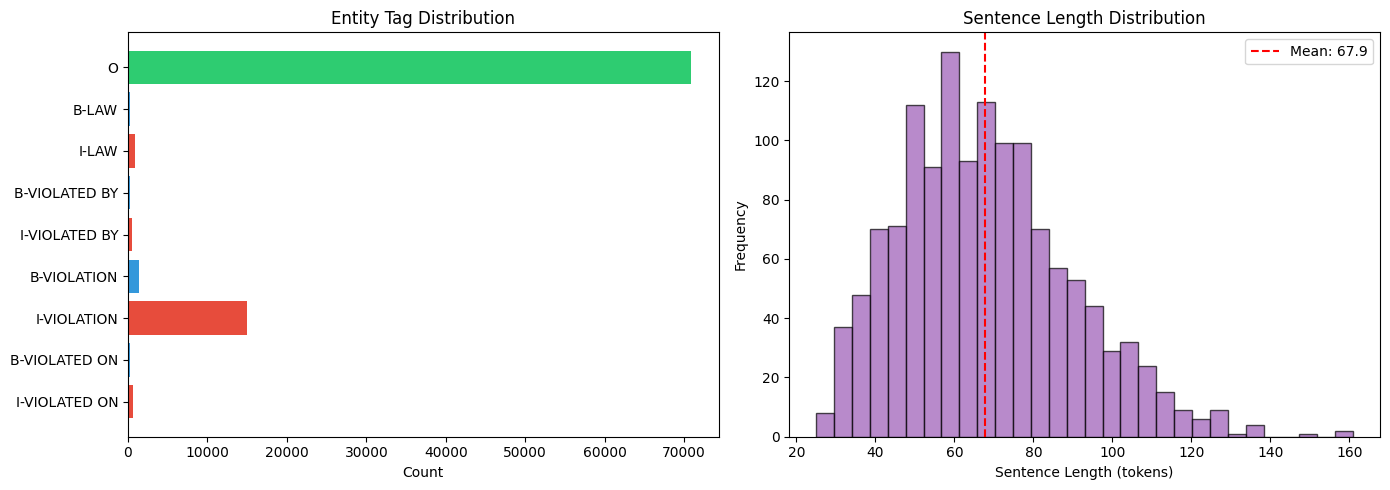


Sentence length stats:
  Min: 25, Max: 161, Mean: 67.9


In [6]:
from collections import Counter
entity_counts = Counter()
for tags in df['ner_tags']:
    entity_counts.update(tags)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
labels_plot = list(entity_counts.keys())
counts_plot = list(entity_counts.values())
colors = ['#2ecc71' if l == 'O' else '#3498db' if l.startswith('B-') else '#e74c3c' for l in labels_plot]
axes[0].barh(labels_plot, counts_plot, color=colors)
axes[0].set_xlabel('Count')
axes[0].set_title('Entity Tag Distribution')
axes[0].invert_yaxis()
sentence_lengths = [len(tokens) for tokens in df['tokens']]
axes[1].hist(sentence_lengths, bins=30, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Sentence Length (tokens)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Sentence Length Distribution')
axes[1].axvline(np.mean(sentence_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(sentence_lengths):.1f}')
axes[1].legend()
plt.tight_layout()
plt.show()
print(f"\nSentence length stats:")
print(f"  Min: {min(sentence_lengths)}, Max: {max(sentence_lengths)}, Mean: {np.mean(sentence_lengths):.1f}")

## 3. Train/Validation/Test Split (80/10/10)

In [7]:
df['label_ids'] = df['ner_tags'].apply(lambda tags: [label2id[tag] for tag in tags])
def get_entity_signature(tags):
    """Create a signature based on which entity types are present"""
    entities = set(tag.split('-')[1] if '-' in tag else 'O' for tag in tags)
    return '_'.join(sorted(entities))
df['entity_signature'] = df['ner_tags'].apply(get_entity_signature)
print(f"Unique entity signatures: {df['entity_signature'].nunique()}")
print(df['entity_signature'].value_counts())
signature_counts = df['entity_signature'].value_counts()
rare_signatures = signature_counts[signature_counts < 2].index.tolist()
if rare_signatures:
    print(f"\nRare signatures (< 2 samples) merged into most common class: {rare_signatures}")
    most_common_signature = signature_counts.index[0]
    df.loc[df['entity_signature'].isin(rare_signatures), 'entity_signature'] = most_common_signature
print(f"\nAdjusted signature distribution:")
print(df['entity_signature'].value_counts())
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['entity_signature'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['entity_signature'])
print(f"\nSplit sizes:")
print(f"  Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Unique entity signatures: 3
entity_signature
O_VIOLATION                                1034
LAW_O_VIOLATED BY_VIOLATED ON_VIOLATION     292
O                                             1
Name: count, dtype: int64

Rare signatures (< 2 samples) merged into most common class: ['O']

Adjusted signature distribution:
entity_signature
O_VIOLATION                                1035
LAW_O_VIOLATED BY_VIOLATED ON_VIOLATION     292
Name: count, dtype: int64

Split sizes:
  Train: 1061 (80.0%)
  Validation: 133 (10.0%)
  Test: 133 (10.0%)


In [8]:
def create_hf_dataset(dataframe):
    """Convert DataFrame to HuggingFace Dataset"""
    return Dataset.from_dict({
        'id': dataframe['id'].tolist(),
        'tokens': dataframe['tokens'].tolist(),
        'ner_tags': dataframe['label_ids'].tolist()
    })
dataset = DatasetDict({
    'train': create_hf_dataset(train_df),
    'validation': create_hf_dataset(val_df),
    'test': create_hf_dataset(test_df)
})
print("Dataset structure:")
print(dataset)
print(f"\nSample from train set:")
print(dataset['train'][0])

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1061
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 133
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 133
    })
})

Sample from train set:
{'id': '8770b871-e314-4afb-8371-c4c2a6dfb3ba', 'tokens': ['in', 'a', 'recent', 'turn', 'of', 'events', ',', 'a', 'popular', 'online', 'gaming', 'platform', 'has', 'been', 'found', 'guilty', 'of', 'breaching', 'player', 'trust', '.', 'the', 'platform', 'has', 'been', 'accused', 'of', 'sending', 'unsolicited', 'in-game', 'messages', 'to', 'advertise', 'their', 'products', 'or', 'services', 'without', 'obtaining', 'prior', 'consent', 'from', 'the', 'players', '.', 'this', 'blatant', 'disregard', 'for', 'player', 'privacy', 'has', 'caused', 'an', 'uproar', 'in', 'the', 'gaming', 'community', '.', 'furthermore', ',', 'the', 'platform', 'c

## 4. Tokenization with -100 Masking for Subwords

Strategy: Assign label only to the first subword token of each word, set `-100` for all subsequent subwords (ignored by CrossEntropyLoss).

In [9]:
def tokenize_and_align_labels(examples, tokenizer, max_length=256):
    """
    Tokenize examples and align labels with -100 masking for subwords.
    Strategy:
    - First subword token of each word gets the word's label
    - Subsequent subwords get -100 (ignored by loss function)
    - Special tokens ([CLS], [SEP], [PAD]) get -100
    """
    tokenized_inputs = tokenizer(
        examples['tokens'],
        truncation=True,
        max_length=max_length,
        is_split_into_words=True,
        padding='max_length'
    )
    labels = []
    for i, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs
print("Tokenization function defined successfully.")

Tokenization function defined successfully.


## 5. Training Configuration & Utilities

Training optimizations:
- **fp16=True**: Mixed precision for memory efficiency
- **gradient_checkpointing=True**: Trade compute for memory
- **lr_scheduler_type="cosine"**: Smoother convergence
- **warmup_ratio=0.1**: Warm start
- **weight_decay=0.01**: L2 regularization
- **Early stopping**: Patience=3 on eval F1

In [10]:
def compute_metrics(eval_pred):
    """Compute entity-level metrics using seqeval"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)
    true_predictions = []
    true_labels = []
    for prediction, label in zip(predictions, labels):
        true_pred = []
        true_label = []
        for p, l in zip(prediction, label):
            if l != -100:  
                true_pred.append(id2label[p])
                true_label.append(id2label[l])
        true_predictions.append(true_pred)
        true_labels.append(true_label)
    pred_entities = sum(1 for seq in true_predictions for tag in seq if tag != 'O')
    true_entities = sum(1 for seq in true_labels for tag in seq if tag != 'O')
    prec = precision_score(true_labels, true_predictions)
    rec = recall_score(true_labels, true_predictions)
    f1 = f1_score(true_labels, true_predictions)
    if f1 == 0 and true_entities > 0:
        print(f"  [DEBUG] Predicted {pred_entities} entities, Ground truth has {true_entities} entities")
    return {
        'precision': prec,
        'recall': rec,
        'f1': f1
    }
def get_training_args(model_name, batch_size=16, gradient_accumulation_steps=1, output_dir="./results", num_epochs=None):
    """Get training arguments with all optimizations"""
    if num_epochs is None:
        num_epochs = TEST_MAX_EPOCHS if TEST_MODE else FULL_MAX_EPOCHS
    lr = 5e-5 if TEST_MODE else 2e-5
    return TrainingArguments(
        output_dir=f"{output_dir}/{model_name}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        warmup_ratio=0.1,
        lr_scheduler_type="cosine",
        fp16=True,  
        gradient_checkpointing=True,  
        gradient_checkpointing_kwargs={"use_reentrant": False},  
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        save_total_limit=2,
        logging_dir=f"{output_dir}/{model_name}/logs",
        logging_steps=10 if TEST_MODE else 50,
        report_to="none",  
        push_to_hub=False,
    )
print("Training utilities defined successfully.")

Training utilities defined successfully.


In [11]:
def train_model(model_checkpoint, dataset, label2id, id2label, 
                batch_size=16, gradient_accumulation_steps=1, max_length=256):
    """
    Train a token classification model with all optimizations.
    Args:
        model_checkpoint: HuggingFace model name
        dataset: DatasetDict with train/validation/test splits
        label2id: Label to ID mapping
        id2label: ID to label mapping
        batch_size: Training batch size
        gradient_accumulation_steps: For effective larger batch size
        max_length: Maximum sequence length
    Returns:
        trainer: Trained Trainer object
        tokenized_dataset: Tokenized dataset for later use
    """
    print(f"\n{'='*60}")
    print(f"Training: {model_checkpoint}")
    print(f"{'='*60}")
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    model = AutoModelForTokenClassification.from_pretrained(
        model_checkpoint,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )
    tokenize_fn = lambda examples: tokenize_and_align_labels(examples, tokenizer, max_length)
    tokenized_dataset = dataset.map(tokenize_fn, batched=True, remove_columns=dataset['train'].column_names)
    data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
    model_name = model_checkpoint.split('/')[-1]
    training_args = get_training_args(
        model_name, 
        batch_size=batch_size, 
        gradient_accumulation_steps=gradient_accumulation_steps
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset['train'],
        eval_dataset=tokenized_dataset['validation'],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )
    print(f"\nStarting training...")
    train_result = trainer.train()
    print(f"\nTraining completed!")
    print(f"Training time: {train_result.metrics['train_runtime']:.2f}s")
    print(f"Samples/second: {train_result.metrics['train_samples_per_second']:.2f}")
    return trainer, tokenized_dataset
print("Model training function defined successfully.")

Model training function defined successfully.


## 6. Model A: DeBERTa-v3-base

Baseline model with proven 86.37% F1 on LegalLensNER dataset.

In [12]:
results = {}
trainers = {}  
batch_size = TEST_BATCH_SIZE if TEST_MODE else FULL_BATCH_SIZE
if TRAIN_DEBERTA_BASE:
    deberta_base_trainer, deberta_base_tokenized = train_model(
        model_checkpoint="microsoft/deberta-v3-base",
        dataset=dataset,
        label2id=label2id,
        id2label=id2label,
        batch_size=batch_size,
        gradient_accumulation_steps=1
    )
    deberta_base_results = deberta_base_trainer.evaluate(deberta_base_tokenized['test'])
    results['DeBERTa-v3-base'] = deberta_base_results
    trainers['DeBERTa-v3-base'] = deberta_base_trainer
    print(f"\nTest Results - DeBERTa-v3-base:")
    print(f"  Precision: {deberta_base_results['eval_precision']:.4f}")
    print(f"  Recall: {deberta_base_results['eval_recall']:.4f}")
    print(f"  F1: {deberta_base_results['eval_f1']:.4f}")
else:
    print(" Skipping DeBERTa-v3-base (TRAIN_DEBERTA_BASE = False)")


Training: microsoft/deberta-v3-base


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Map:   0%|          | 0/1061 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.



Starting training...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.583163,0.006061,0.013636,0.008392
2,1.220400,0.227569,0.479167,0.418182,0.446602
3,0.235900,0.162892,0.509709,0.477273,0.492958
4,0.235900,0.130613,0.684932,0.681818,0.683371
5,0.106400,0.106466,0.650000,0.709091,0.678261
6,0.061100,0.106560,0.722222,0.768182,0.744493
7,0.061100,0.110665,0.699571,0.740909,0.719647
8,0.042800,0.106760,0.710084,0.768182,0.737991
9,0.036700,0.108350,0.700000,0.763636,0.730435



Training completed!
Training time: 534.41s
Samples/second: 19.85



Test Results - DeBERTa-v3-base:
  Precision: 0.6680
  Recall: 0.7309
  F1: 0.6981


## 7. Model B: DeBERTa-v3-large

Larger model with potentially higher accuracy. Uses:
- batch_size=8 with gradient_accumulation_steps=2 (effective batch=16)
- Gradient checkpointing + fp16 critical to fit T4 16GB

In [13]:
import gc
if 'deberta_base_trainer' in dir():
    del deberta_base_trainer
gc.collect()
torch.cuda.empty_cache()
if TRAIN_DEBERTA_LARGE:
    large_batch = max(4, batch_size // 2)  
    deberta_large_trainer, deberta_large_tokenized = train_model(
        model_checkpoint="microsoft/deberta-v3-large",
        dataset=dataset,
        label2id=label2id,
        id2label=id2label,
        batch_size=large_batch,
        gradient_accumulation_steps=2  
    )
    deberta_large_results = deberta_large_trainer.evaluate(deberta_large_tokenized['test'])
    results['DeBERTa-v3-large'] = deberta_large_results
    trainers['DeBERTa-v3-large'] = deberta_large_trainer
    print(f"\nTest Results - DeBERTa-v3-large:")
    print(f"  Precision: {deberta_large_results['eval_precision']:.4f}")
    print(f"  Recall: {deberta_large_results['eval_recall']:.4f}")
    print(f"  F1: {deberta_large_results['eval_f1']:.4f}")
else:
    print(" Skipping DeBERTa-v3-large (TRAIN_DEBERTA_LARGE = False)")


Training: microsoft/deberta-v3-large


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1061 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.



Starting training...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.377919,0.274286,0.218182,0.243038
2,0.785600,0.151739,0.669725,0.663636,0.666667
3,0.121900,0.125243,0.598456,0.704545,0.647182
4,0.121900,0.107094,0.741525,0.795455,0.767544
5,0.046900,0.105510,0.716049,0.790909,0.751620
6,0.021600,0.130313,0.731092,0.790909,0.759825
7,0.021600,0.149655,0.755459,0.786364,0.770601
8,0.011600,0.142199,0.741525,0.795455,0.767544
9,0.008400,0.146585,0.744681,0.795455,0.769231
10,0.008400,0.147232,0.741525,0.795455,0.767544



Training completed!
Training time: 2025.72s
Samples/second: 5.24



Test Results - DeBERTa-v3-large:
  Precision: 0.7198
  Recall: 0.7489
  F1: 0.7341


## 8. Model C: Legal-BERT

Domain-specific model pre-trained on 12GB of legal text. Uses `nlpaueb/legal-bert-base-uncased`.

In [14]:
if 'deberta_large_trainer' in dir():
    del deberta_large_trainer
gc.collect()
torch.cuda.empty_cache()
if TRAIN_LEGAL_BERT:
    legal_bert_trainer, legal_bert_tokenized = train_model(
        model_checkpoint="nlpaueb/legal-bert-base-uncased",
        dataset=dataset,
        label2id=label2id,
        id2label=id2label,
        batch_size=batch_size,
        gradient_accumulation_steps=1
    )
    legal_bert_results = legal_bert_trainer.evaluate(legal_bert_tokenized['test'])
    results['Legal-BERT'] = legal_bert_results
    trainers['Legal-BERT'] = legal_bert_trainer
    print(f"\nTest Results - Legal-BERT:")
    print(f"  Precision: {legal_bert_results['eval_precision']:.4f}")
    print(f"  Recall: {legal_bert_results['eval_recall']:.4f}")
    print(f"  F1: {legal_bert_results['eval_f1']:.4f}")
else:
    print(" Skipping Legal-BERT (TRAIN_LEGAL_BERT = False)")


Training: nlpaueb/legal-bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1061 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.



Starting training...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.649517,0.000000,0.000000,0.000000
2,1.099500,0.275337,0.425121,0.400000,0.412178
3,0.272400,0.182904,0.553571,0.563636,0.558559
4,0.272400,0.159759,0.540230,0.640909,0.586279
5,0.127000,0.151501,0.557971,0.700000,0.620968
6,0.078700,0.144926,0.582090,0.709091,0.639344
7,0.078700,0.165705,0.578358,0.704545,0.635246
8,0.059500,0.156011,0.586957,0.736364,0.653226
9,0.050500,0.160013,0.591078,0.722727,0.650307
10,0.050500,0.158871,0.606061,0.727273,0.661157


  [DEBUG] Predicted 0 entities, Ground truth has 1984 entities

Training completed!
Training time: 429.04s
Samples/second: 24.73



Test Results - Legal-BERT:
  Precision: 0.6255
  Recall: 0.7265
  F1: 0.6722


## 9. Model D: BiLSTM-CRF with GloVe Embeddings

Classical neural sequence labeling architecture combining:
- **GloVe 6B 300d** pre-trained word embeddings (general purpose, fast)
- **Bidirectional LSTM** for contextual representation
- **CRF layer** for sequence-level tag decoding (respects BIO constraints)

**Optimal Hyperparameters (T4 GPU):**
- AdamW optimizer with `lr=0.001`
- `ReduceLROnPlateau` scheduler (patience=2, factor=0.5)
- Gradient clipping at 5.0
- Dropout 0.5 for regularization

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import urllib.request
import zipfile
from tqdm import tqdm
try:
    from torchcrf import CRF
except ModuleNotFoundError:
    print("Installing pytorch-crf...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'pytorch-crf', '-q'])
    from torchcrf import CRF
def load_glove_embeddings(glove_path="glove.6B.300d.txt", embedding_dim=300):
    """Load GloVe embeddings from file or download if not exists"""
    if not os.path.exists(glove_path):
        print(" Downloading GloVe embeddings (this may take a while)...")
        zip_path = "glove.6B.zip"
        if not os.path.exists(zip_path):
            url = "http://nlp.stanford.edu/data/glove.6B.zip"
            urllib.request.urlretrieve(url, zip_path)
        print(" Extracting GloVe embeddings...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extract("glove.6B.300d.txt")
        print(" GloVe embeddings ready!")
    print(f"Loading GloVe embeddings from {glove_path}...")
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe"):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if len(vector) == embedding_dim:
                embeddings_index[word] = vector
    print(f"Loaded {len(embeddings_index)} word vectors")
    return embeddings_index
def build_vocab(datasets, min_freq=1):
    """Build vocabulary from datasets"""
    word_freq = {}
    for split in ['train', 'validation', 'test']:
        for tokens in datasets[split]['tokens']:
            for token in tokens:
                word = token.lower()
                word_freq[word] = word_freq.get(word, 0) + 1
    word2idx = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    for word, freq in word_freq.items():
        if freq >= min_freq:
            word2idx[word] = idx
            idx += 1
    print(f"Vocabulary size: {len(word2idx)}")
    return word2idx
def create_embedding_matrix(word2idx, glove_embeddings, embedding_dim=300):
    """Create embedding matrix from GloVe vectors"""
    vocab_size = len(word2idx)
    embedding_matrix = np.random.uniform(-0.25, 0.25, (vocab_size, embedding_dim))
    embedding_matrix[0] = np.zeros(embedding_dim)  
    found = 0
    for word, idx in word2idx.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]
            found += 1
    print(f"Found {found}/{vocab_size} words in GloVe ({found/vocab_size*100:.1f}%)")
    return embedding_matrix
class NERDataset(Dataset):
    def __init__(self, tokens_list, labels_list, word2idx, label2id, max_len=256):
        self.tokens_list = tokens_list
        self.labels_list = labels_list
        self.word2idx = word2idx
        self.label2id = label2id
        self.max_len = max_len
    def __len__(self):
        return len(self.tokens_list)
    def __getitem__(self, idx):
        tokens = self.tokens_list[idx]
        labels = self.labels_list[idx]
        token_ids = [self.word2idx.get(t.lower(), self.word2idx['<UNK>']) for t in tokens]
        label_ids = labels  
        token_ids = token_ids[:self.max_len]
        label_ids = label_ids[:self.max_len]
        seq_len = len(token_ids)
        padding_len = self.max_len - seq_len
        token_ids = token_ids + [0] * padding_len
        label_ids = label_ids + [0] * padding_len  
        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'labels': torch.tensor(label_ids, dtype=torch.long),
            'seq_len': seq_len
        }
def collate_fn(batch):
    """Custom collate function to handle variable length sequences"""
    input_ids = torch.stack([item['input_ids'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    seq_lens = torch.tensor([item['seq_len'] for item in batch])
    return {'input_ids': input_ids, 'labels': labels, 'seq_lens': seq_lens}
class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_labels, 
                 num_layers=2, dropout=0.5, embedding_matrix=None):
        super(BiLSTM_CRF, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = True  
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers=num_layers,
            batch_first=True, 
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.hidden2tag = nn.Linear(hidden_dim * 2, num_labels)
        self.crf = CRF(num_labels, batch_first=True)
    def forward(self, input_ids, seq_lens, labels=None):
        embeds = self.embedding(input_ids)
        embeds = self.dropout(embeds)
        packed = nn.utils.rnn.pack_padded_sequence(
            embeds, seq_lens.cpu(), batch_first=True, enforce_sorted=False
        )
        lstm_out, _ = self.lstm(packed)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        lstm_out = self.dropout(lstm_out)
        emissions = self.hidden2tag(lstm_out)
        actual_max_len = emissions.shape[1]
        mask = torch.zeros((input_ids.shape[0], actual_max_len), dtype=torch.bool, device=input_ids.device)
        for i, length in enumerate(seq_lens):
            mask[i, :length] = True
        if labels is not None:
            labels = labels[:, :actual_max_len]
            loss = -self.crf(emissions, labels, mask=mask, reduction='mean')
            return loss
        else:
            predictions = self.crf.decode(emissions, mask=mask)
            return predictions
print(" BiLSTM-CRF model architecture defined")

Installing pytorch-crf...
✅ BiLSTM-CRF model architecture defined


In [16]:
if 'legal_bert_trainer' in dir():
    del legal_bert_trainer
gc.collect()
torch.cuda.empty_cache()
if TRAIN_BILSTM_CRF:
    print("\n" + "="*60)
    print("Training: BiLSTM-CRF with GloVe Embeddings")
    print("="*60)
    config = BILSTM_CONFIG['test'] if TEST_MODE else BILSTM_CONFIG['full']
    print(f"Configuration: {config}")
    glove_embeddings = load_glove_embeddings()
    word2idx = build_vocab(dataset)
    embedding_matrix = create_embedding_matrix(word2idx, glove_embeddings)
    del glove_embeddings
    gc.collect()
    train_dataset_bilstm = NERDataset(
        dataset['train']['tokens'], 
        dataset['train']['ner_tags'],
        word2idx, label2id
    )
    val_dataset_bilstm = NERDataset(
        dataset['validation']['tokens'],
        dataset['validation']['ner_tags'],
        word2idx, label2id
    )
    test_dataset_bilstm = NERDataset(
        dataset['test']['tokens'],
        dataset['test']['ner_tags'],
        word2idx, label2id
    )
    train_loader = DataLoader(
        train_dataset_bilstm, 
        batch_size=config['batch_size'], 
        shuffle=True, 
        collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_dataset_bilstm, 
        batch_size=config['batch_size'], 
        shuffle=False, 
        collate_fn=collate_fn
    )
    test_loader = DataLoader(
        test_dataset_bilstm, 
        batch_size=config['batch_size'], 
        shuffle=False, 
        collate_fn=collate_fn
    )
    bilstm_model = BiLSTM_CRF(
        vocab_size=len(word2idx),
        embedding_dim=300,
        hidden_dim=config['hidden_dim'],
        num_labels=len(label2id),
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        embedding_matrix=embedding_matrix
    ).to(device)
    optimizer = AdamW(bilstm_model.parameters(), lr=config['lr'])
    scheduler = None
    if not TEST_MODE:
        scheduler = ReduceLROnPlateau(
            optimizer, mode='max', 
            patience=config['lr_patience'], 
            factor=config['lr_factor']
        )
    best_f1 = -1  
    best_model_state = bilstm_model.state_dict().copy()  
    for epoch in range(config['epochs']):
        bilstm_model.train()
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}")
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            seq_lens = batch['seq_lens']
            optimizer.zero_grad()
            loss = bilstm_model(input_ids, seq_lens, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(bilstm_model.parameters(), config['grad_clip'])
            optimizer.step()
            total_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
        avg_loss = total_loss / len(train_loader)
        bilstm_model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                seq_lens = batch['seq_lens']
                predictions = bilstm_model(input_ids, seq_lens)
                for pred, label, length in zip(predictions, labels, seq_lens):
                    pred_tags = [id2label[p] for p in pred[:length]]
                    true_tags = [id2label[l.item()] for l in label[:length]]
                    all_preds.append(pred_tags)
                    all_labels.append(true_tags)
        val_f1 = f1_score(all_labels, all_preds)
        val_precision = precision_score(all_labels, all_preds)
        val_recall = recall_score(all_labels, all_preds)
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Val F1={val_f1:.4f}, P={val_precision:.4f}, R={val_recall:.4f}")
        if scheduler:
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step(val_f1)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr != old_lr:
                print(f"   Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}")
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_state = bilstm_model.state_dict().copy()
            print(f"   New best model saved (F1={best_f1:.4f})")
    bilstm_model.load_state_dict(best_model_state)
    bilstm_model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            seq_lens = batch['seq_lens']
            predictions = bilstm_model(input_ids, seq_lens)
            for pred, label, length in zip(predictions, labels, seq_lens):
                pred_tags = [id2label[p] for p in pred[:length]]
                true_tags = [id2label[l.item()] for l in label[:length]]
                all_preds.append(pred_tags)
                all_labels.append(true_tags)
    test_f1 = f1_score(all_labels, all_preds)
    test_precision = precision_score(all_labels, all_preds)
    test_recall = recall_score(all_labels, all_preds)
    results['BiLSTM-CRF'] = {
        'eval_precision': test_precision,
        'eval_recall': test_recall,
        'eval_f1': test_f1
    }
    print(f"\n Test Results - BiLSTM-CRF:")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall: {test_recall:.4f}")
    print(f"  F1: {test_f1:.4f}")
else:
    print(" Skipping BiLSTM-CRF (TRAIN_BILSTM_CRF = False)")


Training: BiLSTM-CRF with GloVe Embeddings
Configuration: {'epochs': 15, 'batch_size': 64, 'lr': 0.001, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.5, 'grad_clip': 5.0, 'lr_patience': 2, 'lr_factor': 0.5}
📥 Downloading GloVe embeddings (this may take a while)...
📦 Extracting GloVe embeddings...
✅ GloVe embeddings ready!
Loading GloVe embeddings from glove.6B.300d.txt...


Loading GloVe: 400000it [00:23, 17002.57it/s]


Loaded 400000 word vectors
Vocabulary size: 4829
Found 4663/4829 words in GloVe (96.6%)


Epoch 1/15: 100%|██████████| 17/17 [00:03<00:00,  4.63it/s, loss=45]  


Epoch 1: Loss=69.9151, Val F1=0.0000, P=0.0000, R=0.0000
  ✅ New best model saved (F1=0.0000)


Epoch 2/15: 100%|██████████| 17/17 [00:03<00:00,  5.27it/s, loss=30.3]


Epoch 2: Loss=39.4041, Val F1=0.0656, P=0.0676, R=0.0636
  ✅ New best model saved (F1=0.0656)


Epoch 3/15: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s, loss=28.8]


Epoch 3: Loss=30.0427, Val F1=0.0826, P=0.0758, R=0.0909
  ✅ New best model saved (F1=0.0826)


Epoch 4/15: 100%|██████████| 17/17 [00:03<00:00,  5.27it/s, loss=18.7]


Epoch 4: Loss=24.9003, Val F1=0.2686, P=0.2843, R=0.2545
  ✅ New best model saved (F1=0.2686)


Epoch 5/15: 100%|██████████| 17/17 [00:03<00:00,  5.28it/s, loss=16]  


Epoch 5: Loss=19.3392, Val F1=0.3855, P=0.4103, R=0.3636
  ✅ New best model saved (F1=0.3855)


Epoch 6/15: 100%|██████████| 17/17 [00:03<00:00,  5.31it/s, loss=13.3]


Epoch 6: Loss=15.6116, Val F1=0.4645, P=0.5026, R=0.4318
  ✅ New best model saved (F1=0.4645)


Epoch 7/15: 100%|██████████| 17/17 [00:03<00:00,  5.25it/s, loss=11.6]


Epoch 7: Loss=13.1425, Val F1=0.5012, P=0.5169, R=0.4864
  ✅ New best model saved (F1=0.5012)


Epoch 8/15: 100%|██████████| 17/17 [00:03<00:00,  5.27it/s, loss=10.3]


Epoch 8: Loss=11.0875, Val F1=0.5416, P=0.5672, R=0.5182
  ✅ New best model saved (F1=0.5416)


Epoch 9/15: 100%|██████████| 17/17 [00:03<00:00,  5.23it/s, loss=8.48]


Epoch 9: Loss=9.3795, Val F1=0.5687, P=0.6051, R=0.5364
  ✅ New best model saved (F1=0.5687)


Epoch 10/15: 100%|██████████| 17/17 [00:03<00:00,  5.26it/s, loss=6.65]


Epoch 10: Loss=8.0457, Val F1=0.5522, P=0.6099, R=0.5045


Epoch 11/15: 100%|██████████| 17/17 [00:03<00:00,  5.32it/s, loss=6.04]


Epoch 11: Loss=7.0486, Val F1=0.6161, P=0.6436, R=0.5909
  ✅ New best model saved (F1=0.6161)


Epoch 12/15: 100%|██████████| 17/17 [00:03<00:00,  5.36it/s, loss=7.28]


Epoch 12: Loss=6.6866, Val F1=0.5742, P=0.6061, R=0.5455


Epoch 13/15: 100%|██████████| 17/17 [00:03<00:00,  5.26it/s, loss=5.2] 


Epoch 13: Loss=5.6177, Val F1=0.6434, P=0.6603, R=0.6273
  ✅ New best model saved (F1=0.6434)


Epoch 14/15: 100%|██████████| 17/17 [00:03<00:00,  5.27it/s, loss=7.58]


Epoch 14: Loss=5.7907, Val F1=0.5942, P=0.6340, R=0.5591


Epoch 15/15: 100%|██████████| 17/17 [00:03<00:00,  5.23it/s, loss=3.73]


Epoch 15: Loss=4.9764, Val F1=0.6174, P=0.6079, R=0.6273

📊 Test Results - BiLSTM-CRF:
  Precision: 0.6518
  Recall: 0.6547
  F1: 0.6532


## 12. Model Evaluation & Comparison

In [17]:
if len(results) == 0:
    print(" No models were trained! Check TRAIN_* flags in configuration.")
    comparison_df = pd.DataFrame()
    best_model = None
    best_f1 = 0
else:
    comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Precision': [r['eval_precision'] for r in results.values()],
        'Recall': [r['eval_recall'] for r in results.values()],
        'F1-Score': [r['eval_f1'] for r in results.values()]
    })
    comparison_df = comparison_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)
    print("=" * 70)
    print("MODEL COMPARISON RESULTS (Test Set)")
    if TEST_MODE:
        print("  TEST MODE - Results are from small sample, not representative!")
    print("=" * 70)
    print(comparison_df.to_string(index=False))
    print("=" * 70)
    best_model = comparison_df.iloc[0]['Model']
    best_f1 = comparison_df.iloc[0]['F1-Score']
    print(f"\n Best Model: {best_model} with F1-Score: {best_f1:.4f}")

MODEL COMPARISON RESULTS (Test Set)
           Model  Precision   Recall  F1-Score
DeBERTa-v3-large   0.719828 0.748879  0.734066
 DeBERTa-v3-base   0.668033 0.730942  0.698073
      Legal-BERT   0.625483 0.726457  0.672199
      BiLSTM-CRF   0.651786 0.654709  0.653244

🏆 Best Model: DeBERTa-v3-large with F1-Score: 0.7341


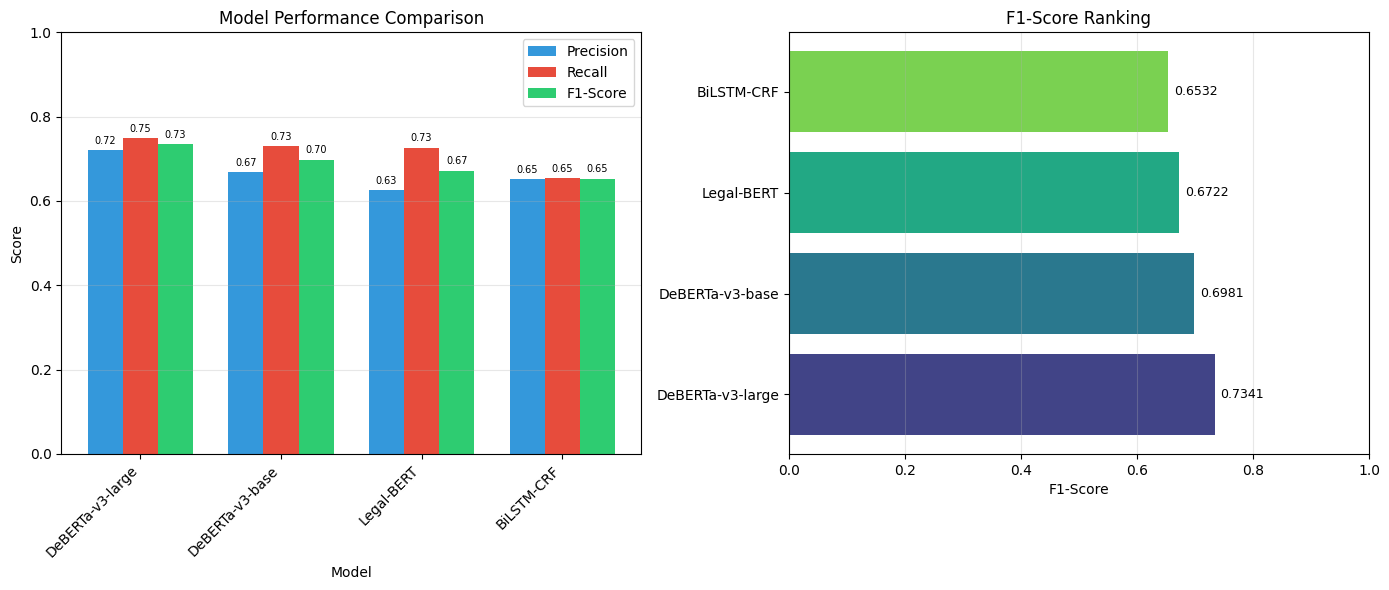


📊 Model Architecture Summary:
--------------------------------------------------
Best Transformer: DeBERTa-v3-large (F1=0.7341)
Best LSTM-based: BiLSTM-CRF (F1=0.6532)


In [18]:
if len(comparison_df) > 0:
    num_models = len(comparison_df)
    fig_width = max(14, num_models * 2)
    fig, axes = plt.subplots(1, 2, figsize=(fig_width, 6))
    x = np.arange(len(comparison_df))
    width = 0.25
    bars1 = axes[0].bar(x - width, comparison_df['Precision'], width, label='Precision', color='#3498db')
    bars2 = axes[0].bar(x, comparison_df['Recall'], width, label='Recall', color='#e74c3c')
    bars3 = axes[0].bar(x + width, comparison_df['F1-Score'], width, label='F1-Score', color='#2ecc71')
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('Score')
    axes[0].set_title('Model Performance Comparison' + (' (TEST MODE)' if TEST_MODE else ''))
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    axes[0].legend()
    axes[0].set_ylim(0, 1)
    axes[0].grid(axis='y', alpha=0.3)
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            axes[0].annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=7)
    import matplotlib.cm as cm
    colors = cm.viridis(np.linspace(0.2, 0.8, len(comparison_df)))
    bars = axes[1].barh(comparison_df['Model'], comparison_df['F1-Score'], color=colors)
    axes[1].set_xlabel('F1-Score')
    axes[1].set_title('F1-Score Ranking')
    axes[1].set_xlim(0, 1)
    axes[1].grid(axis='x', alpha=0.3)
    for bar, f1 in zip(bars, comparison_df['F1-Score']):
        axes[1].text(f1 + 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{f1:.4f}', va='center', fontsize=9)
    plt.tight_layout()
    plt.show()
    print("\n Model Architecture Summary:")
    print("-" * 50)
    transformer_models = ['DeBERTa-v3-base', 'DeBERTa-v3-large', 'Legal-BERT']
    lstm_models = ['BiLSTM-CRF']
    trained_transformers = [m for m in comparison_df['Model'] if m in transformer_models]
    trained_lstm = [m for m in comparison_df['Model'] if m in lstm_models]
    if trained_transformers:
        best_transformer = comparison_df[comparison_df['Model'].isin(transformer_models)].iloc[0]
        print(f"Best Transformer: {best_transformer['Model']} (F1={best_transformer['F1-Score']:.4f})")
    if trained_lstm:
        best_lstm = comparison_df[comparison_df['Model'].isin(lstm_models)].iloc[0]
        print(f"Best LSTM-based: {best_lstm['Model']} (F1={best_lstm['F1-Score']:.4f})")
else:
    print("No results to visualize.")

## 13. Detailed Classification Report (Best Model)

In [19]:
import gc
if 'bilstm_model' in dir():
    pass
gc.collect()
torch.cuda.empty_cache()
if len(comparison_df) > 0 and best_model is not None:
    def get_detailed_classification_report_hf(trainer, tokenized_dataset, id2label):
        """Generate detailed classification report for HuggingFace models"""
        print("Running predictions on test set...")
        predictions = trainer.predict(tokenized_dataset['test'])
        preds = np.argmax(predictions.predictions, axis=2)
        labels = predictions.label_ids
        true_predictions = []
        true_labels = []
        for pred, label in zip(preds, labels):
            true_pred = []
            true_label = []
            for p, l in zip(pred, label):
                if l != -100:
                    true_pred.append(id2label[p])
                    true_label.append(id2label[l])
            true_predictions.append(true_pred)
            true_labels.append(true_label)
        print("\n" + "=" * 70)
        print("DETAILED CLASSIFICATION REPORT")
        if TEST_MODE:
            print("  TEST MODE - Results are from small sample!")
        print("=" * 70)
        print(classification_report(true_labels, true_predictions))
        return true_labels, true_predictions
    best_model_name = comparison_df.iloc[0]['Model']
    print(f"Generating detailed report for: {best_model_name}")
    model_checkpoints = {
        'DeBERTa-v3-base': 'microsoft/deberta-v3-base',
        'DeBERTa-v3-large': 'microsoft/deberta-v3-large',
        'Legal-BERT': 'nlpaueb/legal-bert-base-uncased'
    }
    if best_model_name in model_checkpoints:
        for var_name in ['deberta_base_trainer', 'deberta_large_trainer', 'legal_bert_trainer']:
            if var_name in dir():
                exec(f'del {var_name}')
        gc.collect()
        torch.cuda.empty_cache()
        print(f"GPU memory cleaned up before loading {best_model_name}")
        checkpoint = model_checkpoints[best_model_name]
        model_dir = f"./results/{checkpoint.split('/')[-1]}"
        if os.path.exists(model_dir):
            checkpoints = [d for d in os.listdir(model_dir) if d.startswith('checkpoint-')]
            if checkpoints:
                best_checkpoint = sorted(checkpoints, key=lambda x: int(x.split('-')[1]))[-1]
                best_model_path = os.path.join(model_dir, best_checkpoint)
                print(f"Loading model from: {best_model_path}")
                tokenizer = AutoTokenizer.from_pretrained(checkpoint)
                model = AutoModelForTokenClassification.from_pretrained(
                    best_model_path,
                    num_labels=len(label2id),
                    id2label=id2label,
                    label2id=label2id
                )
                model.to(device)
                data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
                tokenize_fn = lambda examples: tokenize_and_align_labels(examples, tokenizer)
                print("Tokenizing dataset...")
                tokenized_dataset = dataset.map(tokenize_fn, batched=True, remove_columns=dataset['train'].column_names)
                training_args = TrainingArguments(
                    output_dir="./tmp_eval",
                    per_device_eval_batch_size=8,  
                    report_to="none",
                    fp16=True
                )
                trainer = Trainer(
                    model=model,
                    args=training_args,
                    tokenizer=tokenizer,
                    data_collator=data_collator,
                    compute_metrics=compute_metrics
                )
                true_labels, true_predictions = get_detailed_classification_report_hf(trainer, tokenized_dataset, id2label)
            else:
                print(f"No checkpoints found in {model_dir}")
        else:
            print(f"Model directory not found: {model_dir}")
            print("Please ensure training was completed successfully.")
    elif best_model_name == 'BiLSTM-CRF':
        print("Best model is BiLSTM-CRF - generating detailed report...")
        if 'bilstm_model' in dir() and 'test_loader' in dir():
            bilstm_model.eval()
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for batch in test_loader:
                    input_ids = batch['input_ids'].to(device)
                    labels = batch['labels'].to(device)
                    seq_lens = batch['seq_lens']
                    predictions = bilstm_model(input_ids, seq_lens)
                    for pred, label, length in zip(predictions, labels, seq_lens):
                        pred_tags = [id2label[p] for p in pred[:length]]
                        true_tags = [id2label[l.item()] for l in label[:length]]
                        all_preds.append(pred_tags)
                        all_labels.append(true_tags)
            print("\n" + "=" * 70)
            print("DETAILED CLASSIFICATION REPORT - BiLSTM-CRF")
            if TEST_MODE:
                print("  TEST MODE - Results are from small sample!")
            print("=" * 70)
            print(classification_report(all_labels, all_preds))
        else:
            print("BiLSTM-CRF model not found in memory. Re-run training cell.")
else:
    print(" No models to generate report for.")

Generating detailed report for: DeBERTa-v3-large
GPU memory cleaned up before loading DeBERTa-v3-large
Loading model from: ./results/deberta-v3-large/checkpoint-340
Tokenizing dataset...


Map:   0%|          | 0/1061 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Running predictions on test set...



DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

         LAW       0.89      0.83      0.86        30
 VIOLATED BY       0.84      0.87      0.85        30
 VIOLATED ON       0.58      0.63      0.60        30
   VIOLATION       0.77      0.81      0.79       133

   micro avg       0.77      0.80      0.78       223
   macro avg       0.77      0.79      0.78       223
weighted avg       0.77      0.80      0.78       223



## 14. Inference Example

In [20]:
def predict_entities(text, model, tokenizer, id2label):
    """
    Predict entities in a given text.
    Args:
        text: Input text string
        model: Trained model
        tokenizer: Tokenizer
        id2label: ID to label mapping
    Returns:
        List of (token, entity) tuples
    """
    tokens = text.split()
    inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
        max_length=256
    )
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=2)
    word_ids = inputs.word_ids() if hasattr(inputs, 'word_ids') else tokenizer(tokens, is_split_into_words=True).word_ids()
    token_predictions = []
    previous_word_idx = None
    for idx, word_idx in enumerate(word_ids):
        if word_idx is not None and word_idx != previous_word_idx:
            pred_id = predictions[0][idx].item()
            token_predictions.append((tokens[word_idx], id2label[pred_id]))
        previous_word_idx = word_idx
    return token_predictions
example_text = "The company violated employment laws by requiring their employees to work overtime without compensation."
print("=" * 70)
print("INFERENCE EXAMPLE")
print("=" * 70)
print(f"\nInput text: {example_text}\n")
if 'model' in dir() and model is not None:
    predictions = predict_entities(example_text, model, tokenizer, id2label)
    print("Predicted entities:")
    print("-" * 40)
    for token, entity in predictions:
        if entity != 'O':
            print(f"  {token:20s} -> {entity}")
    print("\nFull sequence:")
    for token, entity in predictions:
        color = '\033[92m' if entity.startswith('B-') else '\033[94m' if entity.startswith('I-') else '\033[0m'
        print(f"{color}{token} ({entity})\033[0m", end=" ")
    print()
else:
    print("Model not loaded. Please run the training cells first.")

INFERENCE EXAMPLE

Input text: The company violated employment laws by requiring their employees to work overtime without compensation.

Predicted entities:
----------------------------------------
  The                  -> B-VIOLATED BY
  company              -> I-VIOLATED BY
  employment           -> B-LAW
  laws                 -> I-LAW
  requiring            -> B-VIOLATION
  their                -> I-VIOLATION
  employees            -> I-VIOLATION
  to                   -> I-VIOLATION
  work                 -> I-VIOLATION
  overtime             -> I-VIOLATION
  without              -> I-VIOLATION
  compensation.        -> I-VIOLATION

Full sequence:
The (B-VIOLATED BY) company (I-VIOLATED BY) violated (O) employment (B-LAW) laws (I-LAW) by (O) requiring (B-VIOLATION) their (I-VIOLATION) employees (I-VIOLATION) to (I-VIOLATION) work (I-VIOLATION) overtime (I-VIOLATION) without (I-VIOLATION) compensation. (I-VIOLATION) 


## 15. Sample Predictions from Each Model

In [21]:
num_samples = 5
sample_indices = list(range(min(num_samples, len(test_df))))
print("=" * 80)
print("SAMPLE PREDICTIONS COMPARISON")
print("=" * 80)
all_model_predictions = {}
sample_tokens_list = [test_df.iloc[i]['tokens'] for i in sample_indices]
sample_tags_list = [test_df.iloc[i]['ner_tags'] for i in sample_indices]
def format_entities(tokens, tags):
    """Format tokens with their tags, highlighting entities"""
    result = []
    for token, tag in zip(tokens, tags):
        if tag != 'O':
            result.append(f"[{token}]({tag})")
        else:
            result.append(token)
    return ' '.join(result)
def extract_entities(tokens, tags):
    """Extract entities as a list"""
    entities = []
    current_entity = []
    current_type = None
    for token, tag in zip(tokens, tags):
        if tag.startswith('B-'):
            if current_entity:
                entities.append((' '.join(current_entity), current_type))
            current_entity = [token]
            current_type = tag[2:]
        elif tag.startswith('I-') and current_type:
            current_entity.append(token)
        else:
            if current_entity:
                entities.append((' '.join(current_entity), current_type))
            current_entity = []
            current_type = None
    if current_entity:
        entities.append((' '.join(current_entity), current_type))
    return entities
for model_name, trainer in trainers.items():
    print(f"\n{'='*60}")
    print(f"Model: {model_name}")
    print(f"{'='*60}")
    tokenizer = trainer.tokenizer
    model = trainer.model
    model.eval()
    predictions_list = []
    for idx, tokens in enumerate(sample_tokens_list):
        inputs = tokenizer(
            tokens,
            is_split_into_words=True,
            return_tensors="pt",
            truncation=True,
            max_length=256,
            padding=True
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=2)[0].cpu().numpy()
        word_ids = tokenizer(tokens, is_split_into_words=True).word_ids()
        pred_tags = []
        prev_word_idx = None
        for i, word_idx in enumerate(word_ids):
            if word_idx is not None and word_idx != prev_word_idx:
                if i < len(preds):
                    pred_tags.append(id2label[preds[i]])
                else:
                    pred_tags.append('O')
            prev_word_idx = word_idx
        pred_tags = pred_tags[:len(tokens)]
        while len(pred_tags) < len(tokens):
            pred_tags.append('O')
        predictions_list.append(pred_tags)
    all_model_predictions[model_name] = predictions_list
if 'bilstm_model' in dir() and bilstm_model is not None and TRAIN_BILSTM_CRF:
    print(f"\n{'='*60}")
    print(f"Model: BiLSTM-CRF")
    print(f"{'='*60}")
    bilstm_model.eval()
    predictions_list = []
    for idx, tokens in enumerate(sample_tokens_list):
        token_ids = [word2idx.get(t.lower(), word2idx['<UNK>']) for t in tokens]
        seq_len = len(token_ids)
        max_len = 256
        padding_len = max_len - seq_len
        token_ids = token_ids[:max_len] + [0] * max(0, padding_len)
        input_tensor = torch.tensor([token_ids], dtype=torch.long).to(device)
        seq_lens = torch.tensor([min(seq_len, max_len)])
        with torch.no_grad():
            preds = bilstm_model(input_tensor, seq_lens)[0]
        pred_tags = [id2label[p] for p in preds[:len(tokens)]]
        predictions_list.append(pred_tags)
    all_model_predictions['BiLSTM-CRF'] = predictions_list
print("\n" + "=" * 80)
print("DETAILED SAMPLE COMPARISONS")
print("=" * 80)
for i in range(len(sample_indices)):
    tokens = sample_tokens_list[i]
    true_tags = sample_tags_list[i]
    max_display = 50
    if len(tokens) > max_display:
        tokens_display = tokens[:max_display]
        true_tags_display = true_tags[:max_display]
        truncated = True
    else:
        tokens_display = tokens
        true_tags_display = true_tags
        truncated = False
    print(f"\n{''*80}")
    print(f" Sample {i+1}:")
    print(f"{''*80}")
    sentence = ' '.join(tokens_display)
    if truncated:
        sentence += " [...]"
    print(f"\nSentence: {sentence[:200]}{'...' if len(sentence) > 200 else ''}")
    true_entities = extract_entities(tokens_display, true_tags_display)
    print(f"\n Ground Truth Entities:")
    if true_entities:
        for entity, etype in true_entities:
            print(f"    {entity}  {etype}")
    else:
        print("   (No entities)")
    for model_name in all_model_predictions:
        pred_tags = all_model_predictions[model_name][i]
        if len(pred_tags) > max_display:
            pred_tags = pred_tags[:max_display]
        pred_entities = extract_entities(tokens_display, pred_tags)
        print(f"\n {model_name} Predictions:")
        if pred_entities:
            for entity, etype in pred_entities:
                is_correct = (entity, etype) in true_entities
                marker = "" if is_correct else ""
                print(f"   {marker} {entity}  {etype}")
        else:
            print("   (No entities predicted)")
print("\n" + "=" * 80)
print("FINAL RESULTS SUMMARY")
print("=" * 80)
if len(results) > 0:
    print("\n" + comparison_df.to_string(index=False))
    print(f"\n Best Model: {best_model} (F1 = {best_f1:.4f})")
else:
    print("No models were trained.")

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


SAMPLE PREDICTIONS COMPARISON

Model: DeBERTa-v3-base


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



Model: DeBERTa-v3-large


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



Model: Legal-BERT

Model: BiLSTM-CRF

DETAILED SAMPLE COMPARISONS

────────────────────────────────────────────────────────────────────────────────
📝 Sample 1:
────────────────────────────────────────────────────────────────────────────────

Sentence: in a shocking revelation , it has been discovered that a prominent financial institution has been implicated in a scandal involving unauthorized transactions . the institution has been found to be exe...

🎯 Ground Truth Entities:
   • executing unauthorized transactions in their clients accounts , leading to significant financial losses for the clients → VIOLATION

🤖 DeBERTa-v3-base Predictions:
   ✅ executing unauthorized transactions in their clients accounts , leading to significant financial losses for the clients → VIOLATION

🤖 DeBERTa-v3-large Predictions:
   ✅ executing unauthorized transactions in their clients accounts , leading to significant financial losses for the clients → VIOLATION

🤖 Legal-BERT Predictions:
   ✅ executing

## Summary

This notebook implements and compares **4 NER models** across different architectures for Legal NER:

### Transformer-Based Models

| Model | Description | Optimizer | LR Scheduler | Batch Size |
|-------|-------------|-----------|--------------|------------|
| **DeBERTa-v3-base** | Proven baseline, strong general performance | AdamW (lr=2e-5) | Cosine + 10% warmup | 16 |
| **DeBERTa-v3-large** | Larger capacity, higher accuracy | AdamW (lr=2e-5) | Cosine + 10% warmup | 8 (grad_accum=2) |
| **Legal-BERT** | Pre-trained on 12GB legal text | AdamW (lr=2e-5) | Cosine + 10% warmup | 16 |

### LSTM-Based Models

| Model | Description | Optimizer | LR Scheduler | Batch Size |
|-------|-------------|-----------|--------------|------------|
| **BiLSTM-CRF** | GloVe 300d + BiLSTM + CRF layer | AdamW (lr=0.001) | ReduceLROnPlateau (patience=2) | 64 |

### Training Optimizations Applied

**Transformers:**
-  Mixed precision (fp16) - 50% memory reduction
-  Gradient checkpointing - Essential for large models on T4
-  Cosine LR scheduler with warmup (10%)
-  Weight decay (0.01) - L2 regularization
-  Early stopping (patience=3) on eval F1

**BiLSTM-CRF:**
-  Pre-trained GloVe 6B 300d embeddings (fine-tuned)
-  CRF layer for BIO tag constraint satisfaction
-  Gradient clipping at 5.0
-  ReduceLROnPlateau for adaptive learning

### Entity Types
- `LAW` - References to laws, acts, regulations
- `VIOLATION` - Description of violations
- `VIOLATED BY` - Entity committing the violation
- `VIOLATED ON` - Victim of the violation

### TEST_MODE
Set `TEST_MODE = True` in the configuration cell to run quick validation with:
- Reduced sample size (300 samples)
- Fewer epochs
- Adjusted hyperparameters for faster convergence